In [1]:
import kmodels as kmk
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch
os.getcwd()

'c:\\Users\\efons\\Desktop\\kalyn_lstm\\kmk'

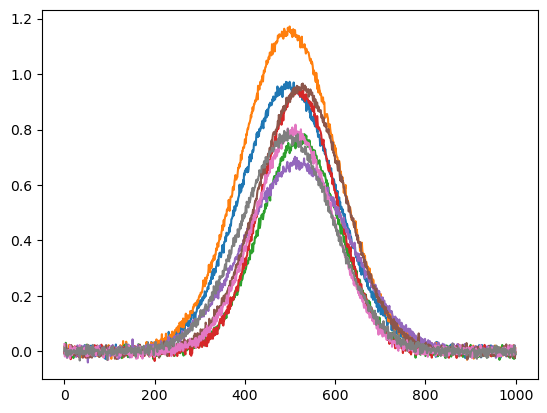

In [2]:
# test the model

# create a time series of a gaussian sigmal with 8 features. make the gaussian signal have a peak at t_mu and a width of t_sigma. The gaussian signal will be the same for all 8 features. For each feature we will add a random 
# number to the t_mu and t_sigma. This will create a time series of 8 features that are all correlated with each other. 
x = np.linspace(0, 100, 1000)
gau_signals = []
t_mu = 50
for i in range(8):
    t_mu += np.random.normal(0, 1)
    t_sigma = 10 + np.random.normal(0, 1)
    # create a prefactor that varies from 0.8-1.2
    A = 0.8 + np.random.normal(0, 0.2)
    noise = np.random.normal(0, 0.1, 1000)*0.1
    gau_signals.append(A * np.exp(-((x - t_mu)**2 / (2 * t_sigma**2))) + noise)

# plot
for i in range(8):
    plt.plot(gau_signals[i])

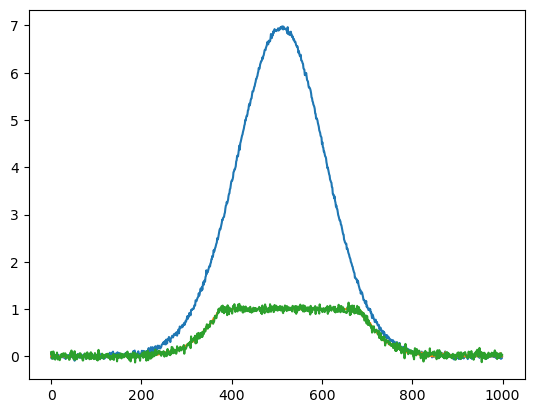

In [3]:
# make the force output signal by correlating a linear ramping function with the gaussian signals. add a time delay to the force signal. make the signal saturate at 1.0
y = []
gau_sum = np.sum(gau_signals, axis=0)
plt.plot(gau_sum)
force = np.linspace(0, 1, 1000)
force = force * gau_sum
# the force should saturate at 1
force = np.clip(force, 0, 1)
plt.plot(force)
# add noise to the force signal
force = force + np.random.normal(0, 0.1, 1000)*0.5
plt.plot(force)


In [109]:
# lets make a subject class that will store the arrays for the time series data. 
# the subject class will also have a method to create a dataset from the time series data.
# we will later use this class to efficeintly produce a fake dataset for testing the model. 

class subject():
    def __init__(self, time, t_mu=50, t_sigma=10):
        # generate the fake EMG signals 
        EMGS = []
        self.t_mu = t_mu
        self.t_sigma = t_sigma
        for i in range(8):
            t_mu += np.random.normal(0, 1)
            t_sigma = 10 + np.random.normal(0, 1)
            # create a prefactor that varies from 0.8-1.2
            A = 0.8 + np.random.normal(0, 0.2)
            noise = np.random.normal(0, 0.1, 1000)*0.1
            EMGS.append(A * np.exp(-((time - t_mu)**2 / (2 * t_sigma**2))) + noise)
        
        # make the force output signal by correlating a linear ramping function with the gaussian signals. add a time delay to the force signal. make the signal saturate at 1.0
        gau_sum = np.sum(EMGS, axis=0)
        force = np.linspace(0, 1, 1000)
        force = force * gau_sum * np.convolve(gau_sum, np.ones(100), 'same')
        force = np.clip(force, 0, 1)
        force = force + np.random.normal(0, 0.1, 1000)*0.5
        force = force.reshape(-1, 1)
        self.EMGS = EMGS
        self.force = force
        return

    def get_force(self):
        return self.force
    def get_EMG(self):
        return self.EMGS
    
    def make_dataset(self, EMGS, force, window_size=100, stride=10):
        # create a dataset from the EMG signals and the force signal
        # the dataset will be a list of tuples. Each tuple will be a window of EMG signals and a window of force signals.
        # the window size and stride will be used to create the windows
        dataset = []
        for i in range(0, len(EMGS[0]) - window_size, stride):
            EMG_window = []
            for j in range(8):
                EMG_window.append(EMGS[j][i:i+window_size])
            force_window = force[i:i+window_size]
            dataset.append((EMG_window, force_window))
        return dataset


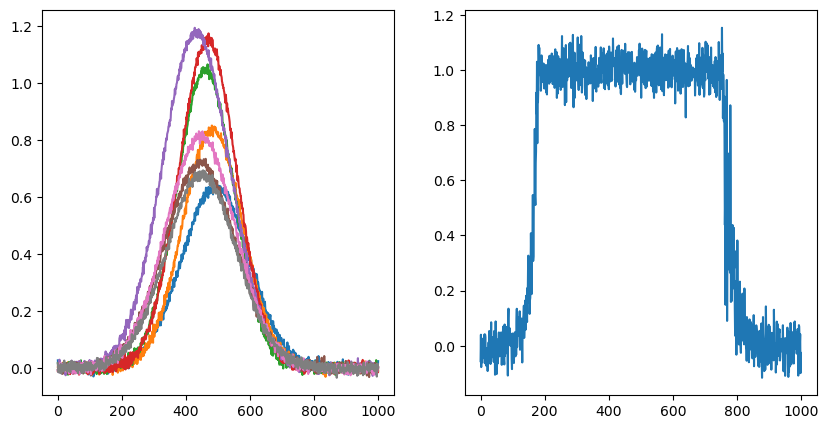

In [110]:
time = np.linspace(0, 100, 1000)
s = subject(time)

# create a dataset from the subject class
data = s.make_dataset(s.EMGS, s.force, window_size=100, stride=10)

# plot x in the left panel and y in the right panel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(8):
    axs[0].plot(s.EMGS[i])

axs[1].plot(s.force)


In [111]:

scaler = StandardScaler()
s.EMGS = scaler.fit_transform(s.EMGS)
s.scaler = scaler
# create a dataset from the subject class
data = s.make_dataset(s.EMGS, s.force, window_size=10, stride=10)

# create a list of tensors for the EMG signals and a list of tensors for the force signals

X = [torch.tensor(x[0]).view(-1,8).float() for x in data]
Y = [torch.tensor(x[1]).float() for x in data]
print(X[0].shape[1]*len(X))

792


In [112]:
class lstm(nn.Module):
    def __init__(self, input_size=8, hidden_size=3, output_size=1, n_linear_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList()
        for i in range(n_linear_layers):
            self.fcs.append(nn.Linear(hidden_size, hidden_size))
        self.output = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        for fc in self.fcs:
            x = fc(x)
        x = self.output(x)
        return x

# test that it works

model = lstm(n_linear_layers=1)
pred =  model(X[0])

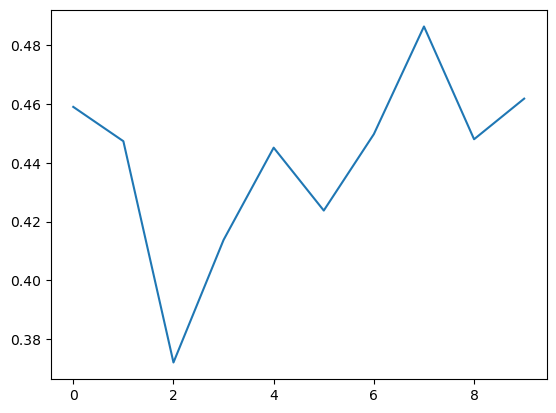

In [113]:
plt.plot(pred.view(-1).detach().numpy())

In [114]:
# make a training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

for i in range(101):
    for j in range(len(X)):
        pred = model(X[j])
        loss = loss_func(pred, Y[j])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print(loss)


tensor(0.2552, grad_fn=<MseLossBackward0>)
tensor(0.0633, grad_fn=<MseLossBackward0>)
tensor(0.0401, grad_fn=<MseLossBackward0>)
tensor(0.0251, grad_fn=<MseLossBackward0>)
tensor(0.0167, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0117, grad_fn=<MseLossBackward0>)
tensor(0.0120, grad_fn=<MseLossBackward0>)
tensor(0.0129, grad_fn=<MseLossBackward0>)
tensor(0.0129, grad_fn=<MseLossBackward0>)
tensor(0.0124, grad_fn=<MseLossBackward0>)


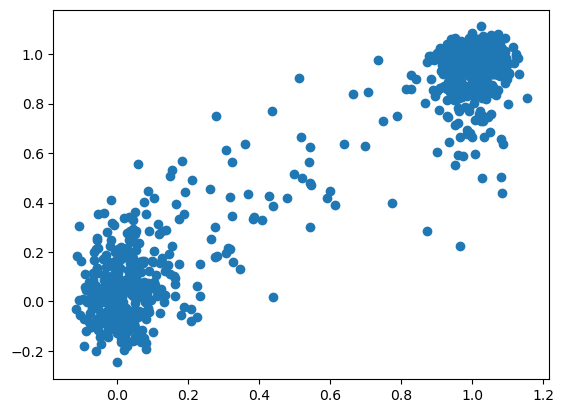

In [115]:
# plot the prediction
pred = model(X[0])
#plt.plot(pred.view(-1).detach().numpy())
#plt.plot(Y[0].view(-1).detach().numpy())

# make a parity plot

x_plot = np.concatenate(Y).ravel()
y_plot = np.concatenate([model(x).view(-1).detach().numpy() for x in X]).ravel()
plt.scatter(x_plot, y_plot)

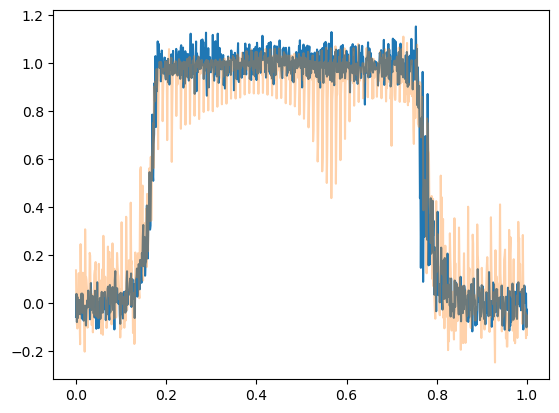

In [116]:
# plot the predictions in sequence
pred_force = torch.stack([model(x).view(-1).detach() for x in X]).view(-1).numpy()
time = np.linspace(0, 1, 1000)
plt.plot(time, s.force)
plt.plot(np.linspace(0, 1, len(pred_force)), pred_force, alpha= 0.35)

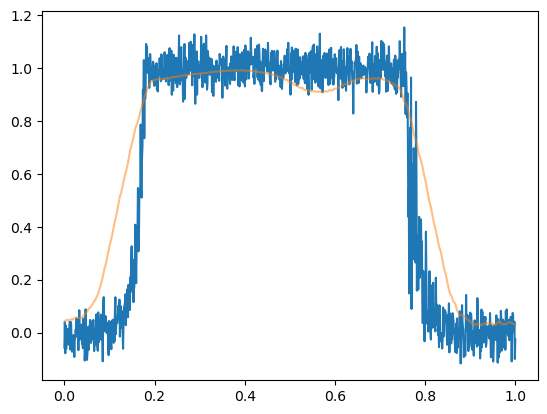

In [117]:
# get a moving averge of the predictions
# use scipy to get the moving average

pred_avg = np.convolve(pred_force, np.ones((100,))/100, mode='valid')
plt.plot(np.linspace(0, 1, len(s.force)) , s.force)
plt.plot(np.linspace(0, 1, len(pred_avg)),pred_avg, alpha= 0.5)


        

In [118]:
model2 = kmk.NN(layers=3, layer_size=10, n_inputs=9, n_outputs=1)


In [119]:
time = np.linspace(0, 1, len(s.force))
X = np.concatenate([s.EMGS.T, time.reshape(-1, 1)], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = s.force
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()
losses = kmk.run_Pytorch(model2, X, Y, n_epochs=101, batch_size=128, device='cuda', learning_rate=1e-3)

EPOCH :  0 , dt:  0.19431281089782715 seconds, losses : 0.6670539975166321
EPOCH :  10 , dt:  1.9011218547821045 seconds, losses : 0.2238077074289322
EPOCH :  20 , dt:  1.872377872467041 seconds, losses : 0.13118381798267365
EPOCH :  30 , dt:  1.8632597923278809 seconds, losses : 0.09209905564785004
EPOCH :  40 , dt:  1.9233357906341553 seconds, losses : 0.07086998969316483
EPOCH :  50 , dt:  1.884162187576294 seconds, losses : 0.05451817810535431
EPOCH :  60 , dt:  1.9061996936798096 seconds, losses : 0.04599856585264206
EPOCH :  70 , dt:  1.8473775386810303 seconds, losses : 0.0407903827726841
EPOCH :  80 , dt:  1.9011671543121338 seconds, losses : 0.03799598664045334
EPOCH :  90 , dt:  1.9834656715393066 seconds, losses : 0.03550197184085846
EPOCH :  100 , dt:  1.8740015029907227 seconds, losses : 0.033466994762420654


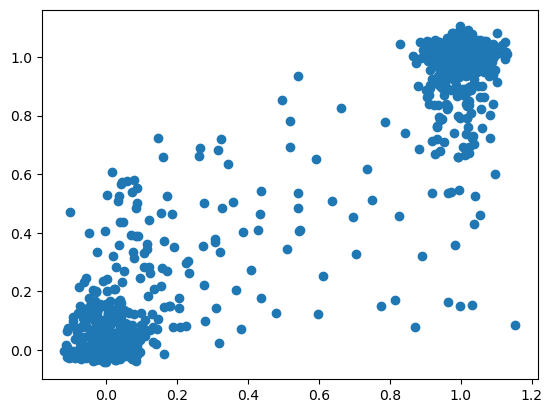

In [120]:
pred2 = model2(X.to('cuda')).to('cpu')
plt.scatter(Y.view(-1).detach().numpy(), pred2.view(-1).detach().numpy())

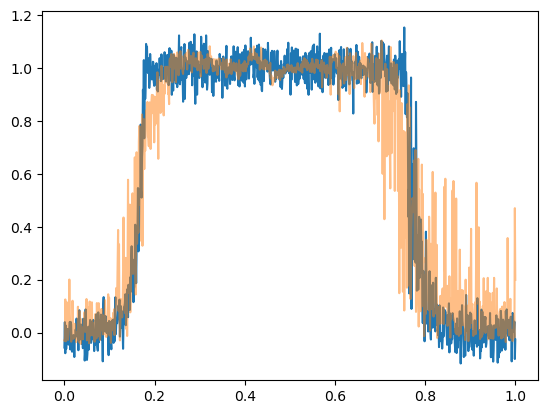

In [121]:
plt.plot(time, s.force)
plt.plot(time, pred2.view(-1).detach().numpy(), alpha=0.5)

RuntimeError: input must have 3 dimensions, got 2

In [127]:
model(X).detach().numpy()

RuntimeError: input.size(-1) must be equal to input_size. Expected 8, got 9